In [1]:
import joblib
best_model = joblib.load('models/xgb_regressor_best_model.pkl')

In [2]:
import pandas as pd
import numpy as np


In [3]:
x_train = pd.read_parquet('data/x_train.parquet')
x_test = pd.read_parquet('data/x_test.parquet')
y_train = pd.read_parquet('data/y_train.parquet')['y_train']
y_test = pd.read_parquet('data/y_test.parquet')['y_test']

In [4]:
# model prediction
y_pred_log = best_model.predict(x_test) 
y_pred = np.expm1(y_pred_log)
y_test_true = np.expm1(y_test)
y_train_true = np.expm1(y_train)

In [5]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [6]:
print('RMSE : ',root_mean_squared_error(y_test_true,y_pred))
print('MAE : ',mean_absolute_error(y_test_true,y_pred))
print('R^2 score : ',r2_score(y_test,y_pred_log))

RMSE :  173573.68514122945
MAE :  82745.38549839919
R^2 score :  0.9068443311146703


In [7]:
# If scores are consistent across folds → model generalizes well.
# If scores vary a lot → your model is sensitive to the data (possible high variance problem)
cv_scores = cross_val_score(best_model,x_train,y_train,scoring='neg_mean_squared_error',n_jobs=-1,cv=5)


In [8]:

cv_scores_rmse = np.sqrt(-cv_scores) #converts the neg_mean_squared_error to root mean squared error
print('Cross validation per fold: ',cv_scores_rmse) # consistent scores mean model generalizes well - low variance
print('Mean CV RMSE: ',cv_scores_rmse.mean()) # how much your model gets it wrong, on average
print('Std CV RMSE: ',cv_scores_rmse.std()) # low standard deviation means model generalizes well


Cross validation per fold:  [0.24628955 0.23503941 0.22099603 0.22585212 0.22661509]
Mean CV RMSE:  0.23095843912362862
Std CV RMSE:  0.008898157806785033


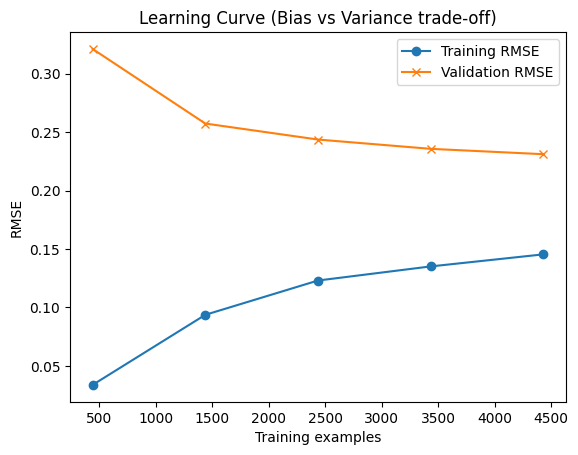

In [9]:
import matplotlib.pyplot as plt
#bias and variance trade-off
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model,x_train,y_train,cv=5,scoring='neg_mean_squared_error',n_jobs=-1,train_sizes=np.linspace(0.1,1.0,5)
)
train_rmse = np.sqrt(-train_scores.mean(axis=1)) #converts mse into rmse, averages the MSE's across the 5 folds
val_rmse = np.sqrt(-val_scores.mean(axis=1)) 

plt.plot(train_sizes,train_rmse,'o-',label='Training RMSE')
plt.plot(train_sizes,val_rmse,'x-',label='Validation RMSE')
plt.xlabel('Training examples')
plt.ylabel('RMSE')
plt.title('Learning Curve (Bias vs Variance trade-off)')
plt.legend()
plt.savefig('plots/learning_curve.png',bbox_inches='tight',dpi=300)
plt.show()


In [10]:

# underfitting - curve is almost flat, training and validation errors are high
# overfitting - training error is low, validation error is high, big gap between curves
# good fit - both errors are low, curves are close together

#high bias - underfitting (training error - high, validation error - high, learning curve - gap btwn curve is close and flat)
# - increase model complexity_add polynomial features
# - reduce regularization
# - train longer 

#high variance - overfitting (training error - low, validation error - high, gap btwn curve is wide apart)
# - get more training data
# - add regularization
# - simplify the model
# - add cross-validation
# - data augumentation, noise ingestion


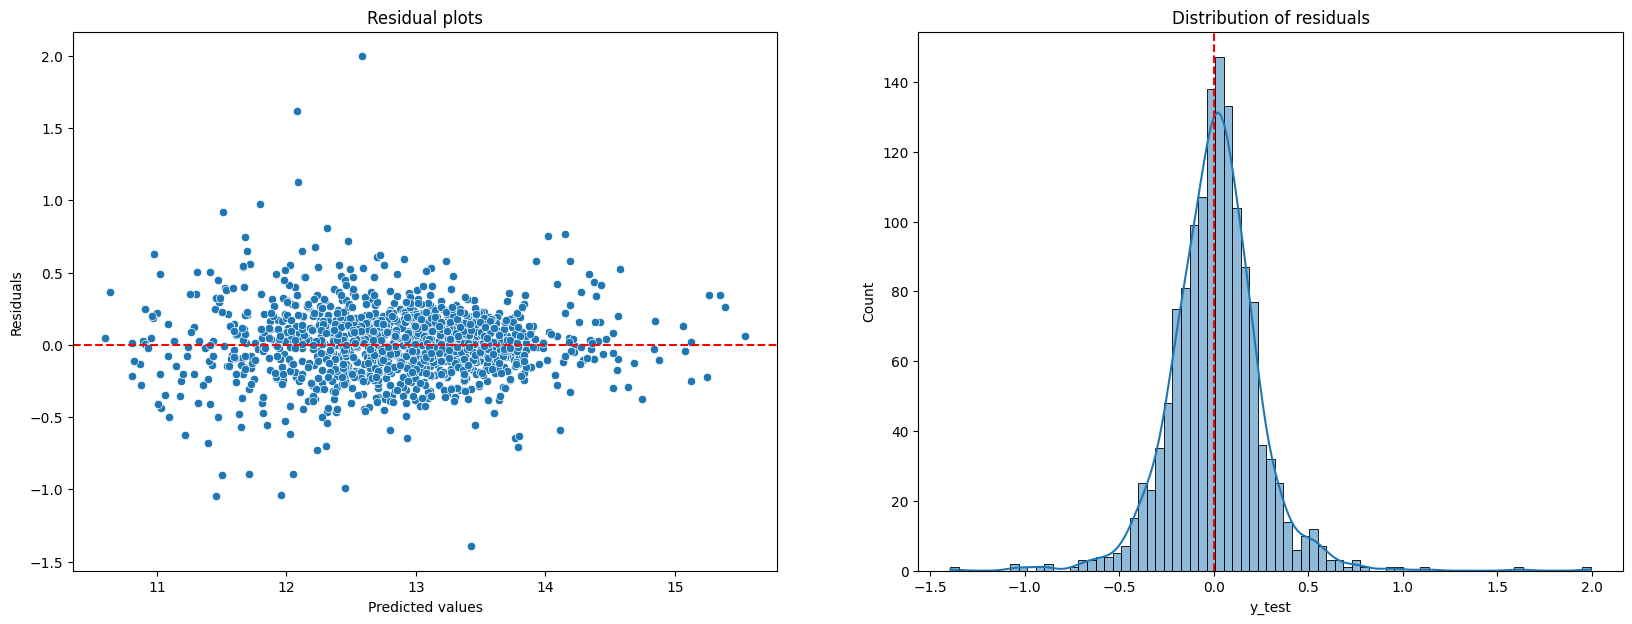

In [11]:
# residuals - difference between predicted and actual values
residuals = y_test - y_pred_log

import seaborn as sns
# residual plots
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred_log,y=residuals)
plt.axhline(0,color='red',linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plots')
# ideal if residuals look like noise around 0
# systematic patterns equals bad model
# bigger errors around edges means model struggles with extreme values
#error distribution
plt.subplot(1,2,2)
sns.histplot(residuals,kde=True)
plt.axvline(color='red',linestyle='--')
plt.title('Distribution of residuals')
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error
#robustness and stress testing
x_test_noisy = x_test.copy()
numeric = x_test_noisy.select_dtypes(include='number').columns
noise = np.random.normal(0,0.1,x_test_noisy[numeric].shape)
x_test_noisy[numeric] = x_test_noisy[numeric] + noise

x_test_noisy_pred = best_model.predict(x_test_noisy)

print('MSE for original prediction: ', mean_squared_error(y_test,y_pred_log))
print('MSE for noisy prediction : ',mean_squared_error(y_test,x_test_noisy_pred))

#small changes in model after adding noise - good robustness
#big changes in model after adding noise - fragile model


MSE for original prediction:  0.05739154644795154
MSE for noisy prediction :  0.07155674741989386
